<a href="https://colab.research.google.com/github/VB-123/OFDM_Capstone/blob/main/OFDM_LS_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.interpolate import griddata

# OFDM Transmitter

#### ToDo:
- functions for grouping
- classes for grouping

In [2]:
bit_stream = np.random.randint(0,2,7752*4)
# np.save('bit_stream.npy', bit_stream)

In [3]:
# CONSTANTS
#N = 64
max_delay = 0
NUM_SC = 612
NUM_SLOTS = 14
cp_length = 144
SIGNAL_LEN = (NUM_SC + cp_length) * NUM_SLOTS
ALPHA = 1/np.sqrt(10) # Normalization factor for QAM Mapping
subcarrier_spacing = 1.5e3
center_frequency = 5e6
#snr_dB = 14
DMRS_CYCLE = np.array([(-1 + 1j), 3 + 1j, 1 - 1j, 1 + 3j]) *ALPHA
DMRS_INDICES = np.linspace(10, 8567, 816, dtype=int)  # using a linear DMRS fashion
DMRS_POSITIONS = np.array([(i % NUM_SC,  i // NUM_SC) for i in DMRS_INDICES])
RESOURCE_GRID = np.zeros((NUM_SC, NUM_SLOTS), dtype=complex)

# sc_idx = subcarrier index, sym_idx = OFDM symbol index
for i, (sc_idx, sym_idx) in enumerate(DMRS_POSITIONS):
    RESOURCE_GRID[sc_idx, sym_idx] = DMRS_CYCLE[i % len(DMRS_CYCLE)]


In [4]:
# Generate Data and modulate

qam_map = {
    (0,0,0,0): ALPHA* (1 + 1j),
    (0,0,0,1): ALPHA* (1 + 3j),
    (0,0,1,1): ALPHA* (1 - 3j),
    (0,0,1,0): ALPHA* (1 - 1j),

    (0,1,0,0): ALPHA* (3 + 1j),
    (0,1,0,1): ALPHA* (3 + 3j),
    (0,1,1,1): ALPHA* (3 - 3j),
    (0,1,1,0): ALPHA* (3 - 1j),

    (1,1,0,0): ALPHA*(-3 + 1j),
    (1,1,0,1): ALPHA*(-3 + 3j),
    (1,1,1,1): ALPHA*(-3 - 3j),
    (1,1,1,0): ALPHA*(-3 - 1j),

    (1,0,0,0): ALPHA*(-1 + 1j),
    (1,0,0,1): ALPHA*(-1 + 3j),
    (1,0,1,1): ALPHA*(-1 - 3j),
    (1,0,1,0): ALPHA*(-1 - 1j),
}

qam_demap = {v: k for k, v in qam_map.items()}

def qam_mapping(bit_stream):
  L = len(bit_stream)
  bit_grps = [tuple(bit_stream[i:i+4]) for i in range(0, L, 4)]
  qam_symbols = [qam_map[grp] for grp in bit_grps]
  return qam_symbols



In [5]:
data_symbols = qam_mapping(bit_stream)
resource_grid = np.copy(RESOURCE_GRID)

dmrs_mask = np.zeros((NUM_SC, NUM_SLOTS), dtype=bool)
for sc_idx, sym_idx in DMRS_POSITIONS:
    dmrs_mask[sc_idx, sym_idx] = True

# Place Data Symbols in the Grid
n = 0 # No. of data symbols counter
data_positions = []
for sym_idx in range(NUM_SLOTS):
  for sc_idx in range(NUM_SC):
    if not dmrs_mask[sc_idx, sym_idx]:
      resource_grid[sc_idx, sym_idx] = data_symbols[n]
      data_positions.append((sc_idx, sym_idx))
      n +=1

In [6]:
# Array of subcarrier frequencies - center frequency = 5 MHz, subcarrier spacing = 15 kHz
f = np.arange(-NUM_SC//2, NUM_SC//2) * subcarrier_spacing + center_frequency
print(DMRS_POSITIONS[:,0])
print("\n", len(DMRS_POSITIONS[:,0]))
# To frequencies to positions
dmrs_frequencies = f[DMRS_POSITIONS[:,0]]  # we only need this for channel simulation

[ 10  20  30  41  51  62  72  83  93 104 114 125 135 146 156 167 177 188
 198 209 219 230 240 251 261 272 282 293 303 314 324 335 345 356 366 377
 387 398 408 419 429 440 450 461 471 482 492 503 513 524 534 545 555 566
 576 587 597 608   6  17  27  38  48  59  69  80  90 101 111 122 132 143
 153 164 174 185 195 206 216 227 237 248 258 269 279 290 300 311 321 332
 342 353 363 374 384 395 405 416 426 437 447 458 468 479 489 500 510 521
 531 542 552 563 573 584 594 605   3  14  24  35  45  56  66  77  87  98
 108 119 129 140 150 161 171 182 192 203 213 224 234 245 255 266 276 287
 297 308 318 329 339 350 360 371 381 392 402 413 423 434 444 455 465 476
 486 497 507 518 528 539 549 560 570 581 591 602   0  11  21  32  42  53
  63  74  84  95 105 116 126 137 147 158 168 179 189 200 210 221 231 242
 252 263 273 284 294 305 315 326 336 347 357 368 378 389 399 410 420 431
 441 452 462 473 483 494 504 515 525 536 546 557 567 578 588 599 609   8
  18  29  39  50  60  71  81  92 102 113 123 134 14

Pilots placed: 816
Data symbols used: 7752
Empty resource elements: 0


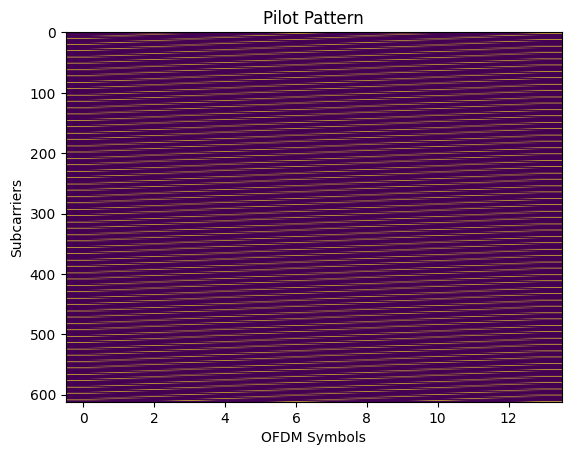

In [7]:
# Resource Grid verification
print(f"Pilots placed: {np.sum(dmrs_mask)}")  # Should be 816
print(f"Data symbols used: {n}")  # Should be 7752
empty_res = np.sum(resource_grid == 0)
print(f"Empty resource elements: {empty_res}")  # Should be 0
plt.imshow(dmrs_mask, aspect='auto')  # .T for proper time/freq orientation
plt.ylabel('Subcarriers')
plt.xlabel('OFDM Symbols')
plt.title('Pilot Pattern')

np.save('resource_grid.npy', resource_grid)

if not (resource_grid == np.load('resource_grid.npy')).all():
  raise ValueError("Resource Grid not matching")

In [8]:
# OFDM and Transmission
# Extract each OFDM symbol (column) for processing
time_domain_symbols = []
for sym_idx in range(NUM_SLOTS):
    frequency_domain_symbol = resource_grid[:, sym_idx]  # 612 subcarriers
    time_domain_symbol = np.fft.ifft(frequency_domain_symbol, 612)
    time_domain_symbols.append(time_domain_symbol)
# Add Cyclic Prefix
cp_length = 144
symbols_with_cp = []
for time_symbol in time_domain_symbols:
    symbol_with_cp = np.concatenate([time_symbol[-cp_length:], time_symbol])
    symbols_with_cp.append(symbol_with_cp)
transmitted_signal = np.concatenate(symbols_with_cp)
# TRANSMITTER
print("=== TRANSMITTER ===")
print(f"Generated {len(data_symbols)} QAM symbols from {len(bit_stream)} bits")
print(f"Placed {np.sum(dmrs_mask)} pilots and {n} data symbols")
print(f"Transmitted signal length: {len(transmitted_signal)}")

=== TRANSMITTER ===
Generated 7752 QAM symbols from 31008 bits
Placed 816 pilots and 7752 data symbols
Transmitted signal length: 10584


## OFDM Transmission System Summary
So far, we have implemented the OFDM Transmission. We generated a bitstream, applied QAM Mapping, then added pilot symbols. Here, we could have added pilots before modulation and modulated the pilots too, but that was pretty confusing to implement - as I had to add 4 bits and they will be modulated and DMRS Indices are hard to calculate. So, I added the QAM symbols corresponding to inputs 1000, 0100, 0010 and 0001 as DMRS symbols.
Then, the symbols are arranged in the 612 * 14 Resource Grid and the same is plotted for reference.

## AWGN Channel
Simulating the AWGN channel and collecting metrics - MSE, BER

In [9]:
# AWGN Channel
def add_AWGN(signal, snr_dB):
  signal_power = np.mean(np.abs(signal)**2)
  snr = 10 ** (snr_dB/10)
  noise_power = signal_power/snr
  noise_real = np.random.normal(0, np.sqrt(noise_power/2), len(signal))
  noise_imag = np.random.normal(0, np.sqrt(noise_power/2), len(signal))
  noise = noise_real + 1j * noise_imag
  received_signal = signal + noise

  return received_signal, noise

In [10]:
def square_distance(cmplx1, cmplx2):
  return (cmplx1.real - cmplx2.real)**2 + (cmplx1.imag - cmplx2.imag)**2

# turns complex number into bit pattern corrsesponding to closest QAM symbol
def ML_Decoder(qam_symbol):
  qam_symbols = list(qam_demap.keys())
  min_index = np.argmin([square_distance(qam_symbol, sym) for sym in qam_symbols])
  closest_symbol = qam_symbols[min_index]
  return qam_demap[closest_symbol]

# Adds pad_length elements from end of qam_symbols to beginnging
def cyclic_prefix(qam_symbols, pad_length):
  return qam_symbols[-pad_length:] + qam_symbols

# Maps list of complex numbers to a list of bits
def qam_demapping(qam_symbols):
  decoded_bits = []
  for symbol in qam_symbols:
    bits = ML_Decoder(symbol)
    decoded_bits.extend(bits)
  return np.array(decoded_bits)
snr_dB = 24
received_signal, noise = add_AWGN(transmitted_signal, snr_dB)
# CHANNEL - AWGN
print("\n=== CHANNEL ===")
print(f"Added AWGN with SNR = {snr_dB} dB")

print("\n=== RECEIVER ===")
# Receiver
symbol_length = NUM_SC + cp_length
received_symbols = []

for i in range(NUM_SLOTS):
    start_idx = i * symbol_length
    end_idx = start_idx + symbol_length

    if end_idx <= len(received_signal):
        symbol_with_cp = received_signal[start_idx:end_idx]
        symbol_no_cp = symbol_with_cp[cp_length:]
        freq_domain_symbol = np.fft.fft(symbol_no_cp, NUM_SC)
        received_symbols.append(freq_domain_symbol)

# Reconstruct resource grid
received_RESOURCE_GRID = np.zeros((NUM_SC, NUM_SLOTS), dtype=complex)
for sym_idx, freq_symbol in enumerate(received_symbols):
    received_RESOURCE_GRID[:, sym_idx] = freq_symbol

received_data_symbols = []
for sc_idx, sym_idx in data_positions:
    received_data_symbols.append(received_RESOURCE_GRID[sc_idx, sym_idx])

print(f"Extracted {len(received_data_symbols)} received data symbols")

# Demodulate QAM symbols
decoded_bits = qam_demapping(received_data_symbols)
print(f"Decoded {len(decoded_bits)} bits")
def calculate_mse(original_symbols, received_symbols):
    """Calculate Mean Square Error between symbol constellations"""
    if len(original_symbols) != len(received_symbols):
        min_len = min(len(original_symbols), len(received_symbols))
        original_symbols = original_symbols[:min_len]
        received_symbols = received_symbols[:min_len]

    mse = np.mean(np.abs(np.array(original_symbols) - np.array(received_symbols))**2)
    return mse
def calculate_ber(original_bits, decoded_bits):
    """Calculate Bit Error Rate"""
    if len(original_bits) != len(decoded_bits):
        min_len = min(len(original_bits), len(decoded_bits))
        original_bits = original_bits[:min_len]
        decoded_bits = decoded_bits[:min_len]

    errors = np.sum(original_bits != decoded_bits)
    ber = errors / len(original_bits)
    return ber, errors

mse = calculate_mse(data_symbols, received_data_symbols)
print(f"Mean Square Error (MSE): {mse:.6f}")


=== CHANNEL ===
Added AWGN with SNR = 24 dB

=== RECEIVER ===
Extracted 7752 received data symbols
Decoded 31008 bits
Mean Square Error (MSE): 0.003866



=== METRICS ===
Bit Error Rate (BER): 0.000000
Number of bit errors: 0 out of 31008
Mean Square Error (MSE): 0.003866
Target SNR: 24 dB, Measured SNR: 24.01 dB


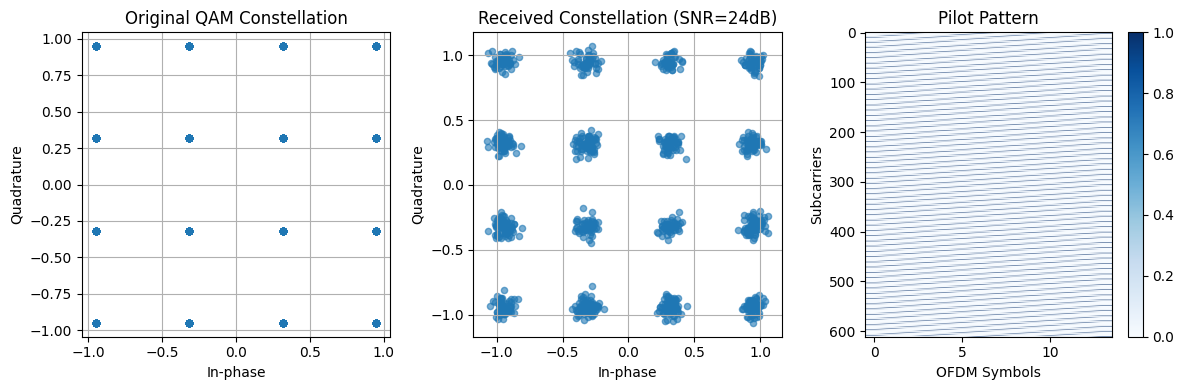


=== BER vs SNR Analysis ===
SNR:  0 dB, BER: 0.287152, MSE: 0.953508
SNR:  2 dB, BER: 0.234907, MSE: 0.614064
SNR:  4 dB, BER: 0.188113, MSE: 0.386888
SNR:  6 dB, BER: 0.139158, MSE: 0.244970
SNR:  8 dB, BER: 0.093879, MSE: 0.154252
SNR: 10 dB, BER: 0.056405, MSE: 0.096147
SNR: 12 dB, BER: 0.025703, MSE: 0.060383
SNR: 14 dB, BER: 0.008417, MSE: 0.038353
SNR: 16 dB, BER: 0.001806, MSE: 0.024115
SNR: 18 dB, BER: 0.000064, MSE: 0.015221
SNR: 20 dB, BER: 0.000000, MSE: 0.009602
SNR: 22 dB, BER: 0.000000, MSE: 0.006000
SNR: 24 dB, BER: 0.000000, MSE: 0.003910

Simulation completed successfully!
Resource grid shape: (612, 14)
Total resource elements: 8568
Pilot overhead: 9.5%


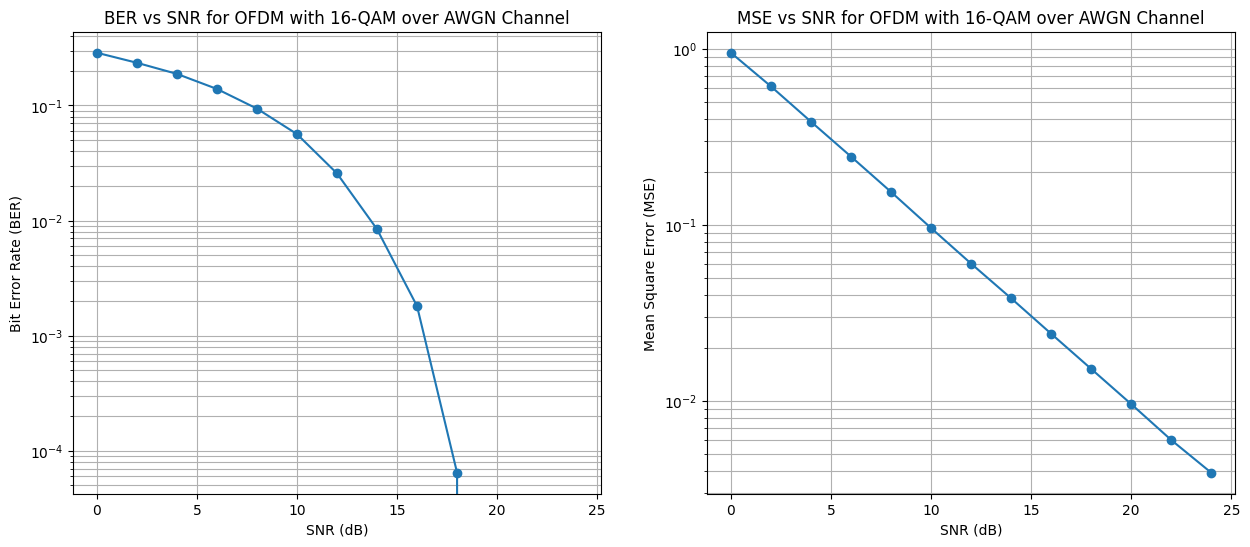

In [11]:
# METRICS
print("\n=== METRICS ===")

# Calculate BER
ber, num_errors = calculate_ber(bit_stream, decoded_bits)
print(f"Bit Error Rate (BER): {ber:.6f}")
print(f"Number of bit errors: {num_errors} out of {len(bit_stream)}")

# Calculate MSE
mse = calculate_mse(data_symbols, received_data_symbols)
print(f"Mean Square Error (MSE): {mse:.6f}")

# Signal-to-Noise Ratio verification
signal_power = np.mean(np.abs(transmitted_signal)**2)
noise_power = np.mean(np.abs(noise)**2)
measured_snr_dB = 10 * np.log10(signal_power / noise_power)
print(f"Target SNR: {snr_dB} dB, Measured SNR: {measured_snr_dB:.2f} dB")

# Plot constellation diagram
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
original_symbols_array = np.array(data_symbols[:1000])  # Plot first 1000 symbols
plt.scatter(original_symbols_array.real, original_symbols_array.imag, alpha=0.6, s=20)
plt.title('Original QAM Constellation')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)

plt.subplot(1, 3, 2)
received_symbols_array = np.array(received_data_symbols[:1000])
plt.scatter(received_symbols_array.real, received_symbols_array.imag, alpha=0.6, s=20)
plt.title(f'Received Constellation (SNR={snr_dB}dB)')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.imshow(dmrs_mask, aspect='auto', cmap='Blues')
plt.ylabel('Subcarriers')
plt.xlabel('OFDM Symbols')
plt.title('Pilot Pattern')
plt.colorbar()

plt.tight_layout()
plt.show()

# BER vs SNR Analysis
print("\n=== BER vs SNR Analysis ===")
snr_range = np.arange(0, 25, 2)
ber_results = []
mse_results = []
for snr in snr_range:
    # Add noise
    noisy_signal, _ = add_AWGN(transmitted_signal, snr)

    # Receiver processing
    rx_symbols = []
    for i in range(NUM_SLOTS):
        start_idx = i * symbol_length
        end_idx = start_idx + symbol_length

        if end_idx <= len(noisy_signal):
            symbol_with_cp = noisy_signal[start_idx:end_idx]
            symbol_no_cp = symbol_with_cp[cp_length:]
            freq_domain_symbol = np.fft.fft(symbol_no_cp, NUM_SC)
            rx_symbols.append(freq_domain_symbol)

    # Reconstruct and extract data
    rx_RESOURCE_GRID = np.zeros((NUM_SC, NUM_SLOTS), dtype=complex)
    for sym_idx, freq_symbol in enumerate(rx_symbols):
        rx_RESOURCE_GRID[:, sym_idx] = freq_symbol

    rx_data_symbols = [rx_RESOURCE_GRID[sc_idx, sym_idx] for sc_idx, sym_idx in data_positions]
    rx_bits = qam_demapping(rx_data_symbols)

    ber_val, _ = calculate_ber(bit_stream, rx_bits)
    ber_results.append(ber_val)
    mse_val = calculate_mse(data_symbols, rx_data_symbols)
    mse_results.append(mse_val)
    print(f"SNR: {snr:2d} dB, BER: {ber_val:.6f}, MSE: {mse_val:.6f}")

# Plot BER vs SNR
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.semilogy(snr_range, ber_results, 'o-')
ax1.set_xlabel('SNR (dB)')
ax1.set_ylabel('Bit Error Rate (BER)')
ax1.set_title('BER vs SNR for OFDM with 16-QAM over AWGN Channel')
ax1.grid(True, which='both')

ax2.semilogy(snr_range, mse_results, 'o-')
ax2.set_xlabel('SNR (dB)')
ax2.set_ylabel('Mean Square Error (MSE)')
ax2.set_title('MSE vs SNR for OFDM with 16-QAM over AWGN Channel')
ax2.grid(True, which='both')


print(f"\nSimulation completed successfully!")
print(f"Resource grid shape: {RESOURCE_GRID.shape}")
print(f"Total resource elements: {NUM_SC * NUM_SLOTS}")
print(f"Pilot overhead: {np.sum(dmrs_mask) / (NUM_SC * NUM_SLOTS) * 100:.1f}%")

# CHANNEL
 We use the TDL-C Channel Model. In TDL (Tapped Delay Line) channel models, the relative powers of the taps (or paths) are typically specified relative to the strongest path, which is often assigned a power of 0 dB. The other taps have lower power levels, reflecting the attenuation of signals arriving at different delays due to multipath propagation. The relative power of each tap indicates how much weaker it is compared to the strongest tap. For example, if a tap has a relative power of -10 dB, it means that its power is 10 dB lower than the strongest tap.

In [12]:
def apply_multipath(path_datas, t_signal):
  r_signal = np.zeros(SIGNAL_LEN, dtype = complex)
  for loss, delay in path_datas:
    for i in range(SIGNAL_LEN):
      r_signal[i] += loss*t_signal[i-delay]
  return r_signal
path_datas = [(1,1),(2,0)]
# assert all(received_signal_multipath == transmitted_signal)

No. of received pilots: 816
Shape of received resource grid: (612, 14)
First 10 subcarriers of first symbol of transmitted resource grid:
 [[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.31622777+0.31622777j]]
First 10 subcarriers of first symbol of received resource grid:
 [[0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [3.58579947-0.36647866j]]
Shape of interpolated channel response: (612, 14)
First 10 subcarriers of first symbol of interpolated channel response:
 [[3.58579947-0.36647866j]
 [3.58579947-0.36647866j]
 [3.58579947-0.36647866j]
 [3.5857994

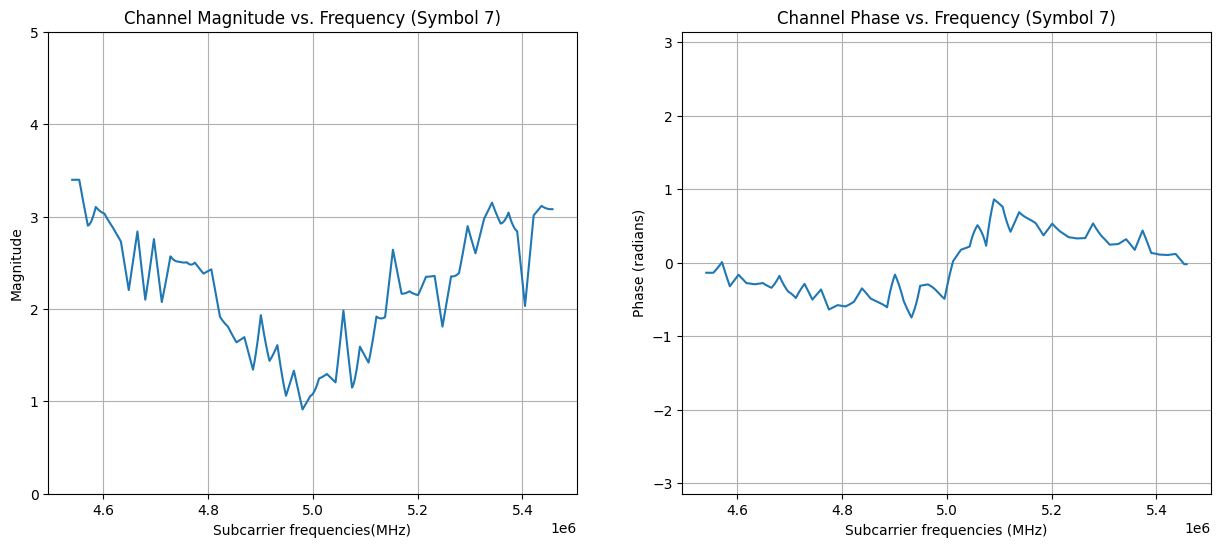

In [13]:
'''
def lin_interpolate(data: array[(x, y)], val):
  for (a1, a2) in data.windows(2):
    x1, y1, x2, y2 = a1, a2
    if x1 < vl < x2:
      # linear interplation on x1,x2,y1,y2
'''
# -- RECEIVER --
def preprocessing(r_signal):
  symbol_length = NUM_SC + cp_length
  received_symbols = []

  for i in range(NUM_SLOTS):
      start_idx = i * symbol_length
      end_idx = start_idx + symbol_length

      if end_idx <= len(r_signal):
          symbol_with_cp = r_signal[start_idx:end_idx]
          symbol_no_cp = symbol_with_cp[cp_length:]
          freq_domain_symbol = np.fft.fft(symbol_no_cp, NUM_SC)
          received_symbols.append(freq_domain_symbol)
  return received_symbols

# Applying method of least squares and performing linear interpolation
def LS_strategy(r_signal, *params):
  received_pilots = [(i,value) for i, value in enumerate(r_signal) if i in DMRS_INDICES]
  print("No. of received pilots:", len(received_pilots))
  channel_response = np.zeros((NUM_SC, NUM_SLOTS), dtype=complex)
  for (idx, val) in received_pilots:
    channel_response[idx % NUM_SC, idx // NUM_SC] = val / RESOURCE_GRID[idx % NUM_SC, idx // NUM_SC]
  return channel_response

def lin_interpolation(x_points, y_points, X):
  results = []
  for x in X:
    if x < x_points[0]:
      results.append (y_points[0])
    elif x > x_points[-1]:
      results.append(y_points[-1])
    else:
      for i in range (len(x_points)-1):
        x1, x2 = x_points[i], x_points[i+1]
        y1, y2 = y_points[i], y_points[i+1]
        if x1 <= x <= x2:
          t = (x - x1) / (x2 - x1)
          results.append(y1 + t * (y2 - y1))
          break
  return np.array(results, dtype = complex)

def channel_interpolation(dmrs_estimate_grid):
  H_est = np.zeros((NUM_SC, NUM_SLOTS), dtype=complex)
  # Interpolation across frequency
  for sym in range(NUM_SLOTS):
    pilot_sc = DMRS_POSITIONS[DMRS_POSITIONS[:,1] == sym, 0]
    pilot_vals = dmrs_estimate_grid[pilot_sc, sym]
    if len(pilot_sc) == 0:
      continue  # no pilots in this symbol
    H_est[:, sym] = lin_interpolation(pilot_sc, pilot_vals, np.arange(NUM_SC))
  return H_est

received_signal_multipath = apply_multipath(path_datas, transmitted_signal)
received_signal_awgn, noise_multipath = add_AWGN(received_signal_multipath, 20)
pre_processed_ofdm_symbols = preprocessing(received_signal_awgn)
flattened_preprocessed_symbols = np.concatenate(pre_processed_ofdm_symbols)
LS_DMRS_Estimate = LS_strategy(flattened_preprocessed_symbols)
interpolated_channel_response = channel_interpolation(LS_DMRS_Estimate)

print("Shape of received resource grid:", LS_DMRS_Estimate.shape)
print("First 10 subcarriers of first symbol of transmitted resource grid:\n", RESOURCE_GRID[:11,:1])
print("First 10 subcarriers of first symbol of received resource grid:\n", LS_DMRS_Estimate[:11,:1])
print("Shape of interpolated channel response:", interpolated_channel_response.shape)
print("First 10 subcarriers of first symbol of interpolated channel response:\n", interpolated_channel_response[:11,:1])

# Verify interpolation
print("\nExample:")
sc_idx, sym_idx = DMRS_POSITIONS[0]
print(f"Original pilot value at ({sc_idx}, {sym_idx}):", LS_DMRS_Estimate[sc_idx, sym_idx])
print(f"Interpolated value at same point: {interpolated_channel_response[sc_idx, sym_idx]}")

# Example of an interpolated (non-pilot) point
non_pilot_sc, non_pilot_sym = (100, 5)
print(f"\nInterpolated non-pilot value at ({non_pilot_sc}, {non_pilot_sym}): {interpolated_channel_response[non_pilot_sc, non_pilot_sym]:.2f}")
symbol_to_plot = 7  # Choose an arbitrary symbol index (e.g., the middle one)
channel_slice = interpolated_channel_response[:, symbol_to_plot]

channel_magnitude = np.abs(channel_slice)
print("Magnitudes:", channel_magnitude[:11])
channel_phase = np.angle(channel_slice)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
subcarrier_indices = np.arange(NUM_SC)
# Plot Magnitude
ax1.plot(f, channel_magnitude)
ax1.set_title(f'Channel Magnitude vs. Frequency (Symbol {symbol_to_plot})')
ax1.set_xlabel('Subcarrier frequencies(MHz)')
ax1.set_ylabel('Magnitude')
ax1.set_ylim(0, 5)
ax1.ticklabel_format(useOffset=False)
ax1.grid(True)

# Plot Phase
ax2.plot(f, channel_phase)
ax2.set_title(f'Channel Phase vs. Frequency (Symbol {symbol_to_plot})')
ax2.set_xlabel('Subcarrier frequencies (MHz)')
ax2.set_ylabel('Phase (radians)')
ax2.set_ylim(-np.pi, np.pi)
ax2.grid(True)

In [14]:
# ZF equalizer and MMSE Equalizer
def zf_equalizer(r_signal, channel_response, epsilon=1e-10):
  return r_signal / np.where(np.abs(channel_response) > epsilon, channel_response, epsilon)

def mmse_equalizer(r_signal, channel_response, noise_var, symbol_power=1.0):
    """
    r_signal: received symbols in frequency domain (after FFT)
    channel_response: estimated channel response H[k]
    noise_var: estimated noise variance (sigma_n^2)
    symbol_power: average transmitted symbol power (sigma_x^2, usually 1 for normalized constellations)
    """
    H_conj = np.conj(channel_response)
    denom = np.abs(channel_response)**2 + noise_var/symbol_power
    return (H_conj / denom) * r_signal

noise_var = np.mean(np.abs(noise_multipath)**2)
rx_symbols = np.array(pre_processed_ofdm_symbols).T
rx_symbols_zf = zf_equalizer(rx_symbols, interpolated_channel_response)
rx_symbols_mmse = mmse_equalizer(rx_symbols, interpolated_channel_response, noise_var)
equalized_zf_grid = np.array(rx_symbols_zf)   # (NUM_SLOTS, NUM_SC)
equalized_mmse_grid = np.array(rx_symbols_mmse)
rx_data_zf = []
rx_data_mmse = []
for sc_idx, sym_idx in data_positions:
    rx_data_zf.append(equalized_zf_grid[sc_idx, sym_idx])
    rx_data_mmse.append(equalized_mmse_grid[sc_idx, sym_idx])

rx_data_zf = np.array(rx_data_zf, dtype=complex)
rx_data_mmse = np.array(rx_data_mmse, dtype=complex)

# Now demap data-only symbols
decoded_bits_zf = qam_demapping(rx_data_zf)      # returns 1D array of bits
decoded_bits_mmse = qam_demapping(rx_data_mmse)
ber_zf, errors_zf = calculate_ber(bit_stream, decoded_bits_zf)
ber_mmse, errors_mmse = calculate_ber(bit_stream, decoded_bits_mmse)

mse_zf = calculate_mse(data_symbols, rx_data_zf)
mse_mmse = calculate_mse(data_symbols, rx_data_mmse)

print(f"SNR = 20 dB")
print(f"ZF  -> BER = {ber_zf}, MSE = {mse_zf}")
print(f"MMSE -> BER = {ber_mmse}, MSE = {mse_mmse}")

SNR = 20 dB
ZF  -> BER = 0.014576883384932921, MSE = 0.04987717787570257
MMSE -> BER = 0.014576883384932921, MSE = 0.04986784760159756


rx_symbols_zf shape: (612, 14)
No. of received pilots: 816
SNR = -4 dB -> ZF BER = 0.4444, ZF MSE = 7.3551, MMSE BER = 0.4444, MMSE MSE = 4.7652
No. of received pilots: 816
SNR = -2 dB -> ZF BER = 0.4099, ZF MSE = 6.8554, MMSE BER = 0.4100, MMSE MSE = 3.9570
No. of received pilots: 816
SNR = 0 dB -> ZF BER = 0.3834, ZF MSE = 4.3472, MMSE BER = 0.3834, MMSE MSE = 3.3376
No. of received pilots: 816
SNR = 2 dB -> ZF BER = 0.3568, ZF MSE = 4.0862, MMSE BER = 0.3568, MMSE MSE = 3.2630
No. of received pilots: 816
SNR = 4 dB -> ZF BER = 0.3089, ZF MSE = 3.5229, MMSE BER = 0.3090, MMSE MSE = 2.9070
No. of received pilots: 816
SNR = 6 dB -> ZF BER = 0.2573, ZF MSE = 2.9238, MMSE BER = 0.2573, MMSE MSE = 2.4585
No. of received pilots: 816
SNR = 8 dB -> ZF BER = 0.2102, ZF MSE = 3.5064, MMSE BER = 0.2101, MMSE MSE = 1.5043
No. of received pilots: 816
SNR = 10 dB -> ZF BER = 0.1700, ZF MSE = 1.1172, MMSE BER = 0.1700, MMSE MSE = 1.0679
No. of received pilots: 816
SNR = 12 dB -> ZF BER = 0.1224, ZF

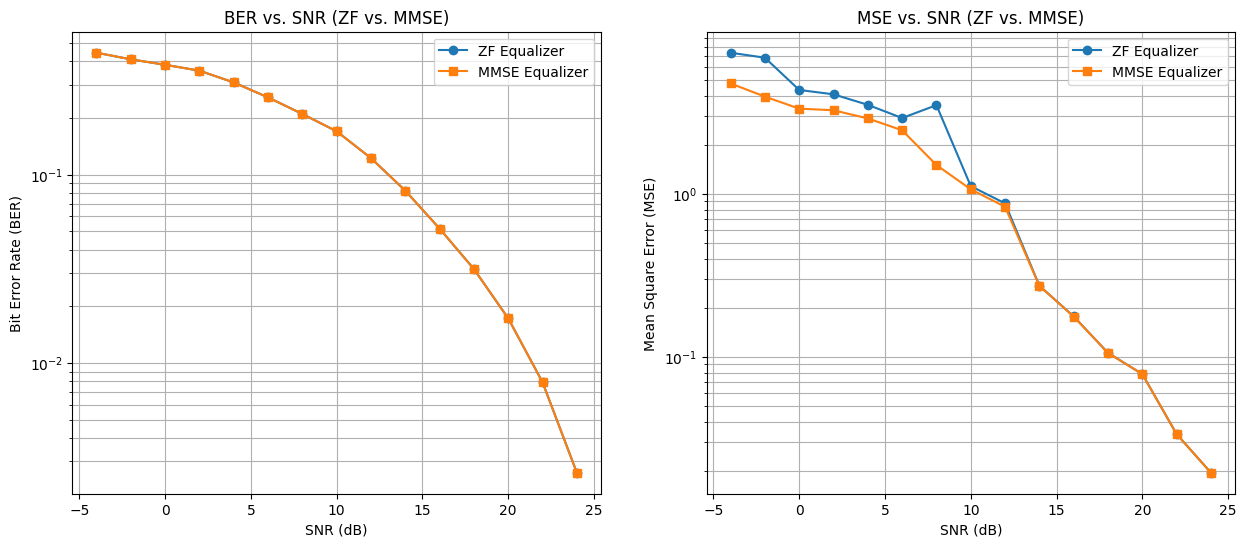

In [15]:
print("rx_symbols_zf shape:", rx_symbols_zf.shape)
snr_range = np.arange(-4,25,2)   # 0, 5, 10, 15, 20, 25 dB
ber_zf_list = []
ber_mmse_list = []
mse_zf_list = []
mse_mmse_list = []
for snr_dB in snr_range:
    # --- Transmit through channel ---
    received_signal_multipath = apply_multipath(path_datas, transmitted_signal)
    received_signal_awgn, noise_multipath = add_AWGN(received_signal_multipath, snr_dB)

    # --- Receiver preprocessing ---
    pre_processed_ofdm_symbols = preprocessing(received_signal_awgn)
    flattened_preprocessed_symbols = np.concatenate(pre_processed_ofdm_symbols)
    LS_DMRS_Estimate = LS_strategy(flattened_preprocessed_symbols)
    interpolated_channel_response = channel_interpolation(LS_DMRS_Estimate)

    # --- Equalization ---
    noise_var = np.mean(np.abs(noise_multipath)**2)
    rx_symbols = np.array(pre_processed_ofdm_symbols).T  # shape (SC, symbols)

    rx_symbols_zf = zf_equalizer(rx_symbols, interpolated_channel_response)
    rx_symbols_mmse = mmse_equalizer(rx_symbols, interpolated_channel_response, noise_var)

    equalized_zf_grid = np.array(rx_symbols_zf)
    equalized_mmse_grid = np.array(rx_symbols_mmse)

    # --- Extract only data subcarriers ---
    rx_data_zf = [equalized_zf_grid[sc_idx, sym_idx] for sc_idx, sym_idx in data_positions]
    rx_data_mmse = [equalized_mmse_grid[sc_idx, sym_idx] for sc_idx, sym_idx in data_positions]

    rx_data_zf = np.array(rx_data_zf, dtype=complex)
    rx_data_mmse = np.array(rx_data_mmse, dtype=complex)

    # --- Demap to bits ---
    decoded_bits_zf = qam_demapping(rx_data_zf)
    decoded_bits_mmse = qam_demapping(rx_data_mmse)

    # --- BER calculation ---
    ber_zf, _ = calculate_ber(bit_stream, decoded_bits_zf)
    ber_mmse, _ = calculate_ber(bit_stream, decoded_bits_mmse)

    ber_zf_list.append(ber_zf)
    ber_mmse_list.append(ber_mmse)

    # --- MSE calculation ---
    mse_zf = calculate_mse(data_symbols, rx_data_zf)
    mse_mmse = calculate_mse(data_symbols, rx_data_mmse)

    mse_zf_list.append(mse_zf)
    mse_mmse_list.append(mse_mmse)

    print(f"SNR = {snr_dB} dB -> ZF BER = {ber_zf:.4f}, ZF MSE = {mse_zf:.4f}, MMSE BER = {ber_mmse:.4f}, MMSE MSE = {mse_mmse:.4f}")

# --- Plot results ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.semilogy(snr_range, ber_zf_list, 'o-', label='ZF Equalizer')
ax1.semilogy(snr_range, ber_mmse_list, 's-', label='MMSE Equalizer')
ax1.set_xlabel('SNR (dB)')
ax1.set_ylabel('Bit Error Rate (BER)')
ax1.set_title('BER vs. SNR (ZF vs. MMSE)')
ax1.grid(True, which='both')
ax1.legend()

ax2.semilogy(snr_range, mse_zf_list, 'o-', label='ZF Equalizer')
ax2.semilogy(snr_range, mse_mmse_list, 's-', label='MMSE Equalizer')
ax2.set_xlabel('SNR (dB)')
ax2.set_ylabel('Mean Square Error (MSE)')
ax2.set_title('MSE vs. SNR (ZF vs. MMSE)')
ax2.grid(True, which='both')
ax2.legend()




In [16]:
def equalize(r_signal, strategy, *params):  # strategy: funcion list[comp], T -> list[comp]
  return strategy(r_signal, params)
avg_energy = np.mean(np.abs(data_symbols)**2)
print("Average symbol energy:", avg_energy)

Average symbol energy: 0.9996904024767802


In [17]:
# --- LMMSE Estimation ---

In [18]:
# Multipath Channel
Avg_Path_Gains = np.array([-13.4000, 0, -2.2000, -4.0000, -6.0000,	-8.2000, -9.9000, -10.5000,	-7.5000,	-15.9000,
                  -6.6000,	-16.7000,	-12.4000, -15.2,	-10.8,	-11.300,	-12.7,	-16.2,	-18.3,	-18.9	,-16.6, -19.9, -29.7])
Channel_Path_Delays = np.array([0,	1.1457e-07,	1.2075e-07,	1.7604e-07,	1.383e-07,	1.6125e-07,	2.0124e-07,	1.725e-07,	2.2854e-07,
                       4.6125e-07,	5.6934e-07,	6.6726e-07,	6.5154e-07,	7.4826e-07,	7.5357e-07,	9.1746e-07,	1.2243e-06,	1.3373e-06,	1.3709e-06,
                       1.439e-06,	1.502e-06,	1.5913e-06,	2.8976e-06])
maxChDelay = 94
SNRdB = 10

def Jakes_model(n, fd, fs):
  """ n :  no. of samples
      fd: doppler shift
      fs: sampling frequency
  """
  N = 16 # No. of scattering points
  h = np.zeros(num_samples, dtype=complex)
  for n in range(N):
    t = np.arange(N)/fs
